#### 데이터 전처리
* info : 피처의 타입과 Null 값 확인
* describe : 각 피처의 값 분포를 확인
* ID 피처는 단순 식별자에 불과하므로 피처를 드롭함
* 데이터 세트를 분리해 별도로 저장함.

#### XGBoost 모델 학습과 하이퍼 파라미터 튜닝
* XGBoost 학습 모델 생성-> 예측결과를 ROC AUC로 평가
* XGBoost는 GBM보다는 빠르지만 GBM을 기반으로 하고 있어서 수행시간이 오래걸림
* 앙상블 계열 알고리즘 : 과접합이나 잡음에 기본적으로 뛰어난 알고리즘임
*plot_importance()메서드 : 각 피처의 중요도를 피처 중요도 그래프로 나타냄

#### LightGBM 모델학습과 하이퍼 파라미터 튜닝
* LightGBM를 직접수행하면 XGBoost보다 학습 시간이 좀 더 단축됐음을 느낄 수 있음
* fmin() : 최적의 하이퍼 파라미터 도출

### 분류 실습
####언더 샘플링과 오버 샘플링의 이해
if 레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬때 예측성능의 문제가 발생할 수 있음
-> 지도학습에서 극도로 불균형 레이블 값 분포로 인한 해결하기 위해서, 오버샘플링과 언더 샘플링이 있다.
* 언더 샘플링 : 많은 데이터 세트 -> 적은 데이터 수준을 감소시키는 방법
* 오베샘플링: 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 충분한 데이터 확보하는 방법
  ex) SMOTE을 구현한 대표적인 파이썬 패키지: imbalanced-learn

#### 데이터 일차 가공 및 모델 학습/예측/평가
* get_preprocessed_df()함수 : 불필요한 Time 피처만 삭제하는 것으로 시작
*  get_train_test_dataset( )은 get_preprocessed_df( )를 호출한 뒤 학습 피처/레이블 데이터 세트, 테스트 피처/레이블 데이터 세트를 반환
* 극도로 불균형한 레이블 값 분포도를 가짐 -> LGBMClassifier 객체 생성시 boost_from_average=False로 파라미터를 설정해야함.
* 사이킷런의 StandardSacler 클래스를 이용해 Amount 피처를 정규 분포 형태로 변환하는 코드로 변경

#### 데이터 분포도 변환 후 모델 학습/예측/평가
* 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우에 적용하는 중요 기법 중 하나임
* log1p()함수를 이용하기

#### 이상치 데이터 제거 후 모델/학습/예측/평가
* 이상치 데이터: 전체 데이터의 패턴에서 벗어난 이상의 값을 가진 데이터
-> 찾는 방법 : IQR방식 작용
* 사분위 : 전체 데이터를 값이 높은 순으로 정렬, 25%씩으로 구간을 분할하는 것
* IQR=Q3-Q1임

#### SMOTE 오버 샘플링 적용후 모델 학습/ 예측/평가
* SMOTE을 적용할때에는 반드시 학습 데이터 세트만 오버 샘플링을 해야함.
* fit_resample()을 이용해 중식한 뒤 데이터를 중식 전과 비교해 보기
* SMOTE를 적용하면 : 재현율이 높아지나. 정밀도는 낮아지는 것이 일반적이다.
-> 좋은 SMOTE패키지일수록 재현율은 높이고 정밀도 감소율은 낮출수 있도록 해야함.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.filterwarnings('ignore')
cust_df=pd.read_csv('/content/train_santander.csv', encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt=cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt=cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [ ]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [ ]:
cust_df['var3'].replace(-999999,2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

#피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features=cust_df.iloc[:,:-1]
y_labels=cust_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X_features, y_labels, test_size=0.2, random_state=0)

train_cnt=y_train.count()
test_cnt=y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


In [ ]:
#X_train, y_train 을 다시 학습과 검증 데이터 세트로 분리
X_tr, X_val, y_tr, y_val=train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

#n_estimators는 500으로, random_state는 예제 수행시마다 동일 예측 결과를 위해 설정
xgb_clf=XGBClassifier(n_estimators=500, random_state=156, learning_rate=0.05, early_stopping_rounds=100, eval_metric='auc')

#성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_val, y_val)])

xgb_roc_score=roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83603	validation_1-auc:0.80978
[1]	validation_0-auc:0.83783	validation_1-auc:0.81126
[2]	validation_0-auc:0.83892	validation_1-auc:0.81192
[3]	validation_0-auc:0.84090	validation_1-auc:0.81349
[4]	validation_0-auc:0.84187	validation_1-auc:0.81356
[5]	validation_0-auc:0.84355	validation_1-auc:0.81422
[6]	validation_0-auc:0.84534	validation_1-auc:0.81550
[7]	validation_0-auc:0.84658	validation_1-auc:0.81623
[8]	validation_0-auc:0.84727	validation_1-auc:0.81669
[9]	validation_0-auc:0.84794	validation_1-auc:0.81668
[10]	validation_0-auc:0.84980	validation_1-auc:0.81828
[11]	validation_0-auc:0.85105	validation_1-auc:0.81965
[12]	validation_0-auc:0.85217	validation_1-auc:0.81999
[13]	validation_0-auc:0.85301	validation_1-auc:0.82049
[14]	validation_0-auc:0.85558	validation_1-auc:0.82210
[15]	validation_0-auc:0.85662	validation_1-auc:0.82288
[16]	validation_0-auc:0.85811	validation_1-auc:0.82380
[17]	validation_0-auc:0.85864	validation_1-auc:0.82365
[18]	validation_0-au

In [ ]:
from hyperopt import hp

#max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
#colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2 사이의 정규 분포된 값으로 검색
xgb_search_space={'max_depth': hp.quniform('max_depth',5,15,1),
                 'min_child_weight': hp.quniform('min_child_weight',1,6,1),
                 'colsample_bytree': hp.uniform('colsample_bytree', 0.5,0.95),
                 'learning_rate': hp.uniform('learning_rate',0.01,0.2)}

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

#fmin()에서 호출 시 search_space 값으로 XGBClassifier 교차 검증 후 -1*roc_auc 평균 값을 반환.
def objective_func(search_space):
    xgb_clf=XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                          min_child_weight=int(search_space['min_child_weight']), colsample_bytree=search_space['colsample_bytree'], learning_rate=search_space['learning_rate'], early_stopping_rounds=30, eval_metric='auc')

    #3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= [ ]

    #3개의 k-fold 방식 적용
    kf=KFold(n_splits=3)

    #X_traind을 다시 학습과 검증용 데이터로 분리
    for tr_index,val_index in kf.split(X_train):
        #kf.splict(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
        X_tr,y_tr=X_train.iloc[tr_index],y_train.iloc[tr_index]
        X_val,y_val=X_train.iloc[val_index],y_train.iloc[val_index]

        #early stopping 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        xgb_clf.fit(X_tr, y_tr,eval_set=[(X_tr, y_tr),(X_val, y_val)])

        #1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음
        score=roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:,1])
        roc_auc_list.append(score)
    #3개의 kfold 로 계산된 roc_auc 값을 평균값을 반환하되
    #HyperOpt로 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한뒤 반환
    return -1*np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials
trials = Trials()
#fmin() 함수를 호출. max.evals지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best=fmin(fn=objective_func, space=xgb_search_space, algo=tpe.suggest, max_evals=50, # 최대 반복 횟수를 지정합니다.
          trials=trials, rstate=np.random.default_rng(seed=30))

print('best:',best)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[0]	validation_0-auc:0.82893	validation_1-auc:0.79630
[1]	validation_0-auc:0.84185	validation_1-auc:0.81151
[2]	validation_0-auc:0.83892	validation_1-auc:0.81016
[3]	validation_0-auc:0.84844	validation_1-auc:0.81883
[4]	validation_0-auc:0.85049	validation_1-auc:0.82190
[5]	validation_0-auc:0.85235	validation_1-auc:0.82399
[6]	validation_0-auc:0.85587	validation_1-auc:0.82399
[7]	validation_0-auc:0.85787	validation_1-auc:0.82579
[8]	validation_0-auc:0.86054	validation_1-auc:0.82705
[9]	validation_0-auc:0.86040	validation_1-auc:0.82705
[10]	validation_0-auc:0.86323	validation_1-auc:0.82919
[11]	validation_0-auc:0.86510	validation_1-auc:0.83027
[12]	validation_0-auc:0.86679	validation_1-auc:0.83074
[13]	validation_0-auc:0.86800	validation_1-auc:0.83093
[14]	validation_0-auc:0.86846	validation_1-auc:0.83219
[15]	validation_0-auc:0.86955	validation_1-auc:0.83237
[16]	validation_0-auc:0.87072	validation_1-auc:0.83218
[17]	validation_0-auc:0.87214	validatio

In [ ]:
#n_estimators를 500 증가후 최적으로 찾은 하이퍼 파라미터를 기반으로 학습과 예측 수행
xgb_clf=XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'],5), max_depth=int(best['max_depth']),
                     min_child_weight=int(best['min_child_weight']), colsample_bytree=round(best['colsample_bytree'],5)
                     ,early_stopping_rounds=100, eval_metric='auc')

#evaluation metrics를 auc로 early stopping은 100으로 설정하고 학습 수행.
xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_val, y_val)])

xgb_roc_score=roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83018	validation_1-auc:0.80525
[1]	validation_0-auc:0.84043	validation_1-auc:0.81460
[2]	validation_0-auc:0.83824	validation_1-auc:0.81236
[3]	validation_0-auc:0.84803	validation_1-auc:0.82040
[4]	validation_0-auc:0.85082	validation_1-auc:0.82147
[5]	validation_0-auc:0.85076	validation_1-auc:0.82291
[6]	validation_0-auc:0.85164	validation_1-auc:0.82304
[7]	validation_0-auc:0.85110	validation_1-auc:0.82269
[8]	validation_0-auc:0.85423	validation_1-auc:0.82449
[9]	validation_0-auc:0.85563	validation_1-auc:0.82733
[10]	validation_0-auc:0.85713	validation_1-auc:0.82694
[11]	validation_0-auc:0.85769	validation_1-auc:0.82804
[12]	validation_0-auc:0.85884	validation_1-auc:0.82859
[13]	validation_0-auc:0.85928	validation_1-auc:0.82845
[14]	validation_0-auc:0.85968	validation_1-auc:0.82828
[15]	validation_0-auc:0.86080	validation_1-auc:0.82815
[16]	validation_0-auc:0.86164	validation_1-auc:0.82834
[17]	validation_0-auc:0.86245	validation_1-auc:0.82915
[18]	validation_0-au

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

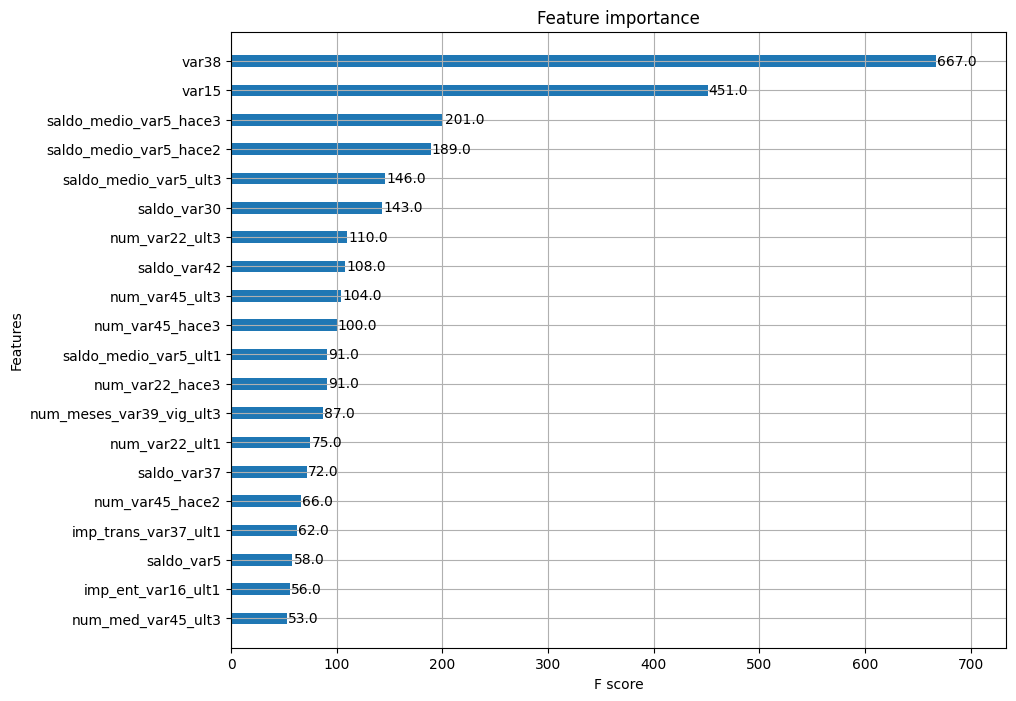

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20, height=0.4)

In [ ]:
from lightgbm import LGBMClassifier
lgbm_clf=LGBMClassifier(n_estimators=500, early_stopping_rounds=100, eval_metric="auc")

eval_set=[(X_tr, y_tr), (X_val, y_val)]
lgbm_clf.fit(X_tr, y_tr, eval_set=eval_set)
lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13308
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 242
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training un

In [ ]:
lgbm_search_space={'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                   'max_depth': hp.quniform('max_depth',100,160,1),
                   'min_child_samples': hp.quniform('min_child_samples',60,100,1),
                   'subsample': hp.uniform('subsample',0.7,1),
                   'learning_rate': hp.uniform('learning_rate',0.01,0.2)
                   }

In [ ]:
def objective_func(search_space):
    lgbm_clf=LGBMClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                          min_child_samples=int(search_space['min_child_samples']),
                            subsample=search_space['subsample'],
                            learning_rate=search_space['learning_rate'], early_stopping_rounds=30, eval_metric='auc')

    #3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    roc_auc_list= [ ]

    #3개의 k-fold 방식 적용
    kf=KFold(n_splits=3)

    #X_traind을 다시 학습과 검증용 데이터로 분리
    for tr_index,val_index in kf.split(X_train):
        #kf.splict(X_train)으로 추출된 학습과 검증 index 값으로 학습과 검증 데이터 세트 분리
        X_tr,y_tr=X_train.iloc[tr_index],y_train.iloc[tr_index]
        X_val,y_val=X_train.iloc[val_index],y_train.iloc[val_index]

        #early stopping 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행
        lgbm_clf.fit(X_tr, y_tr,eval_set=[(X_tr, y_tr),(X_val, y_val)])

        #1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음
        score=roc_auc_score(y_val, lgbm_clf.predict_proba(X_val)[:,1])
        roc_auc_list.append(score)

    #3개의 kfold 로 계산된 roc_auc 값을 평균값을 반환하되
    #HyperOpt로 목적함수의 최솟값을 위한 입력값을 찾으므로 -1을 곱한뒤 반환
    return -1*np.mean(roc_auc_list)

In [ ]:
from hyperopt import fmin, tpe, Trials
trials = Trials()

#fmin() 함수를 호출. max.evals지정된 횟수만큼 반복 후 목적함수의 최솟값을 가지는 최적 입력값 추출
best=fmin(fn=objective_func, space=lgbm_search_space, algo=tpe.suggest, max_evals=50, # 최대 반복 횟수를 지정합니다.
          trials=trials, rstate=np.random.default_rng(seed=30))

print('best:',best)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1579, number of negative: 38965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12827
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 192
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038945 -> initscore=-3.205872
[LightGBM] [Info] Start training from score -3.205872
Training until va

In [ ]:
lgbm_clf=LGBMClassifier(n_estimators=500, learning_rate=round(best['learning_rate'],5), max_depth=int(best['max_depth']),
                     min_child_samples=int(best['min_child_samples']), subsample=round(best['subsample'],5)
                     ,early_stopping_rounds=100, eval_metric='auc')

#evaluation metrics를 auc로 early stopping은 100으로 설정하고 학습 수행.
lgbm_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_val, y_val)])

lgbm_roc_score=roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1])
print('ROC AUC:{0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 1658, number of negative: 40913
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.154550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12898
[LightGBM] [Info] Number of data points in the train set: 42571, number of used features: 192
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.038947 -> initscore=-3.205836
[LightGBM] [Info] Start training from score -3.205836
Training un

In [ ]:
#conda install -c conda-forge imbalanced-learn

In [ ]:
 import pandas as pd
 import numpy as np
 import matplotlib.pyplot as pit
 import warnings
 warnings.filterwarnings("ignore")
 %matplotlib inline

 card_df = pd.read_csv('/content/creditcard.csv')
 card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [ ]:
from sklearn.model_selection import train_test_split
# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy =df.copy()
  df_copy.drop('Time', axis=1,inplace=True)
  return df_copy

In [ ]:
#사전 데이터 가공 후 학습과 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
  #인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features=df_copy.iloc[:,:-1]
  y_target=df_copy.iloc[:,-1]
  #train_test_split()으로 학습과 데이터 분할. stratify=y_target으로 Stratified 기반 분할
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  #학습과 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

In [ ]:
print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 세트 레이블 값 분포 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 세트 레이블 값 분포 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


In [ ]:
 from sklearn.linear_model import LogisticRegression
 from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
 lr_clf = LogisticRegression(max_iter=1000)
 lr_clf.fit(X_train, y_train)
 lr_pred = lr_clf.predict(X_test)
 lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

def get_clf_eval(y_test, pred, pred_proba):
    confusion=confusion_matrix(y_test, pred)
    accuracy=accuracy_score(y_test, pred)
    precision=precision_score(y_test, pred)
    recall=recall_score(y_test, pred)
    f1=f1_score(y_test, pred)
    #ROC-AUC 추가
    roc_auc=roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    #ROC-AUC print 추가
    print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율{2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall,f1,roc_auc))


#3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행.
 get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차행렬
[[85281    14]
 [   57    91]]
정확도:0.9992, 정밀도:0.8667, 재현율0.6149, F1:0.7194, AUC:0.9741


In [ ]:
 #인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:, 1]
  get_clf_eval(tgt_test, pred, pred_proba)

In [ ]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7b9913726020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7b9913726020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Exception ignored on calling ctypes callback function: <function _log_callback at 0x7b9913726020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

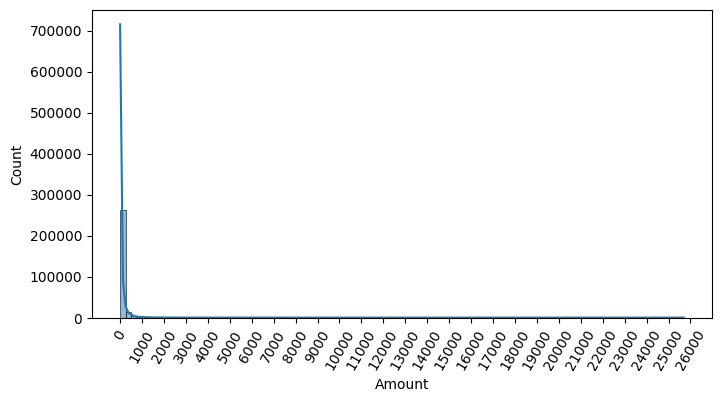

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
#사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정.
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
  #변환된 Amount를 Amount_Scaled로 피처명 변경후 DataFrmae 맨 앞 칼럼으로 입력
  df_copy.insert(0,'Amount—Scaled', amount_n)
  #기존 Time, Amount 피처 삭제
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [ ]:
#Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행.
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('###로지스틱 회귀 예측 성능 ###')
lr_clf=LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

###로지스틱 회귀 예측 성능 ###
오차행렬
[[85281    14]
 [   55    93]]
정확도:0.9992, 정밀도:0.8692, 재현율0.6284, F1:0.7294, AUC:0.9706
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [ ]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  #넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('###로지스틱 회귀 예측 성능###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

###로지스틱 회귀 예측 성능###
오차행렬
[[85282    13]
 [   59    89]]
정확도:0.9992, 정밀도:0.8725, 재현율0.6014, F1:0.7120, AUC:0.9734
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

<Axes: >

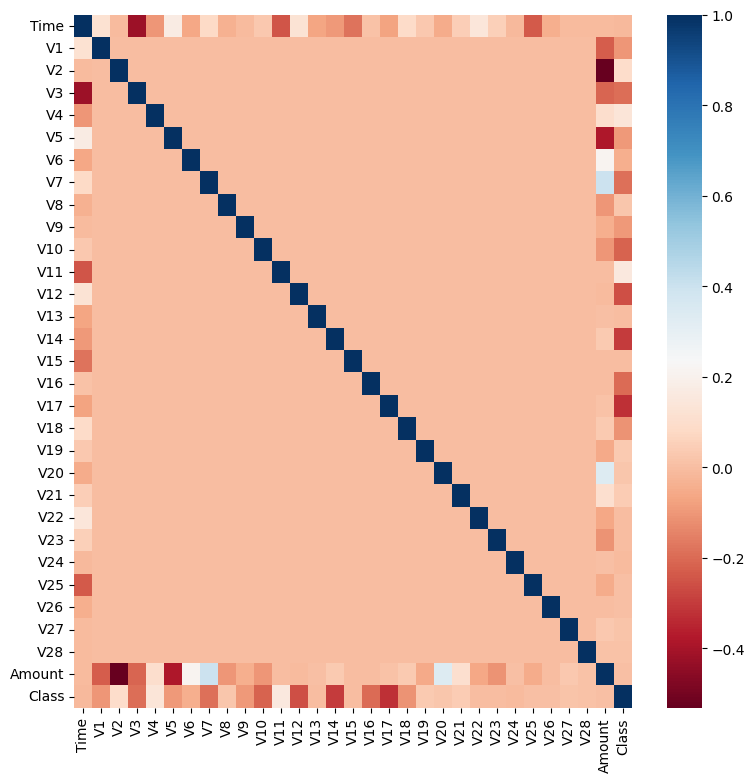

In [ ]:
import seaborn as sns
plt.figure(figsize=(9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [ ]:
import numpy as np
def get_outlier(df=None, column=None, weight=1.5):
  #fraud에 해당하는 column 데이터만 추출, 1/4분위와 3/4분위 지점을 np.percentile로 구함.
  fraud=df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  #IQR을 구하고, IQR에 1.5를 곱해 최댓갑과 최솟값 지점 구함.
  iqr=quantile_75-quantile_25
  iqr_weight=iqr*weight
  lowest_val=quantile_25-iqr_weight
  highest_val=quantile_75+iqr_weight
  #최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환.
  outlier_index=fraud[(fraud < lowest_val)|(fraud > highest_val)].index
  return outlier_index

In [ ]:
outlier_index=get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [ ]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0,'Amount—Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  #이상치 데이터 삭제하는 로직 추가
  outlier_index=get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('###로지스틱 회귀 예측 성능###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

###로지스틱 회귀 예측 성능###
오차행렬
[[85280    15]
 [   48    98]]
정확도:0.9993, 정밀도:0.8673, 재현율0.6712, F1:0.7568, AUC:0.9725
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [ ]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over, y_train_over=smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 전 레이블 값 분포:', pd.Series(y_train).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 전 레이블 값 분포: Class
0    199020
1       342
Name: count, dtype: int64


In [ ]:
lr_clf=LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차행렬
[[82933  2362]
 [   11   135]]
정확도:0.9722, 정밀도:0.0541, 재현율0.9247, F1:0.1022, AUC:0.9736


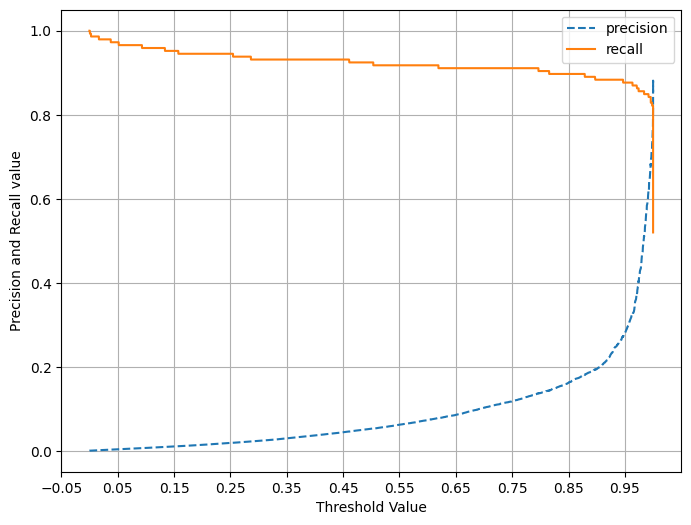

In [ ]:
from sklearn.metrics import precision_recall_curve
def precision_recall_curve_plot(y_test, pred_proba_c1):
    #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds=precision_recall_curve(y_test, pred_proba_c1)

    #X축을 threshold 값으로 Y축은 정밀도, 재현율 순으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary=thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')

    #threshold 값 x축의 Scale을 0.1 단위로 변경
    start,end=plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))

    #x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:,1])

In [ ]:
lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split